In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import ColumnDataSource, Div, Select, Button, ColorBar, CustomJS, TapTool, WheelZoomTool
from bokeh.layouts import row, column, layout
from bokeh.transform import cumsum, linear_cmap
from bokeh.palettes import Blues8
from bokeh.models.widgets import Panel, Tabs
from bokeh.palettes import Colorblind

from datetime import datetime

output_notebook()

#########

gdf = gpd.read_file('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson')
#gdf.head()

#########

data = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv")
#print(data.head())
#print(len(data))

##########


#POUR LA MAP :
geocode = list(set(data.countryterritoryCode))
geoId = gdf["ADM0_A3"].values
xs = []
ys = []

for obj in gdf.geometry.boundary:
    if obj.type == 'LineString':
        obj_x, obj_y = obj.xy
        xs.append([[list(obj_x)]])
        ys.append([[list(obj_y)]])
    elif obj.type == 'MultiLineString':
        obj_x = []
        obj_y = []
        for line in obj:
            line_x, line_y = line.xy
            obj_x.append([list(line_x)])
            obj_y.append([list(line_y)])
        xs.append(obj_x)
        ys.append(obj_y)



#POUR LES DATAS : (pour l'instant, on va faire simple : on va recup que le nombre d'habitant) 
# bon, pour eviter des soucis de check qui va où ... et ce qu'on a des datas .. etc ...
# on va remplir le dataframe recap en faisant une boucle sur les pays present sur la map

hab = []
for pays in geoId:# pour chaque pays sur la map
    #print("pays  :  ",pays)
    fnd = False
    for codedata in geocode: # on cherche ce pays dans les datas
        if (pays == codedata and not fnd): # on l'a trouvé
                fnd = True
                habi = data.loc[data['countryterritoryCode'] == codedata].head(1)["popData2019"].iloc[0]
                #print(habi)
                hab.append(habi)# <= là faut trouver l'info 
                
    if not fnd : 
        hab.append(0)

# Alors .. pour chaque pays .. il me faut nb de jour depuis le 31/12/19
# 
# # jour ; death
#
dataAtracer = []
for pays in geoId:
    dataPays = []
    sys.stdout.write('.')
    #print("COUCCUOUUUUUUUUUUUUUUUUUUUUUUUUUU    :    ",pays)
    df_pays = data.loc[data['countryterritoryCode'] == pays]
    
    if (len(df_pays)>0):
        df_pays=df_pays.iloc[::-1]
        iDeb = df_pays.tail(1).index[0]
        iFin = df_pays.head(1).index[0]

        for ix in range(iFin,iDeb-1,-1):
            #print(df_france.loc[ix])
            dateNowStr = df_pays.loc[ix]["dateRep"]
            nb = datetime.strptime(dateNowStr[:-4]+dateNowStr[-2:],'%d/%m/%y') - datetime.strptime("31/12/19", '%d/%m/%y')
            dataPays.append([nb.days,df_pays.loc[ix]["cases"],df_pays.loc[ix]["deaths"]])
            #print([nb.days,df_pays.loc[ix]["cases"],df_pays.loc[ix]["deaths"]])
    
    dataAtracer.append([dataPays])
        

        
#print("AU FINAL")
print("geoId:",len(geoId),"xs:",len(xs),"ys:",len(ys),"hab:",len(hab), "dat:",len(dataAtracer))
df_plot = pd.DataFrame({'country': geoId, 'xs': xs, 'ys': ys, 'hab': hab, 'dat': dataAtracer})
#df_plot.head()


##########################
# Create the ColumnDataSource object "s_plot"
s_plot = ColumnDataSource(df_plot)

# Create the Figure object "p_test"
p_map = figure(plot_width=775, plot_height=350,
                 toolbar_location=None, tools=['hover', 'pan', 'wheel_zoom'],
                 active_scroll='wheel_zoom', tooltips='@country')

# Add multipolygons to "p_test"
p_map.multi_polygons(xs='xs', ys='ys',  source=s_plot)
# Change parameters of "p_test"
p_map.axis.visible = False
p_map.grid.grid_line_color = None


######## un graph pour les cas confirmés journaliers 
palette = Colorblind[7]

case = dict(x =[[1,2,3]], y = [[1,2,3]], color = [[palette[0]]])
case = pd.DataFrame(case)
s_case = ColumnDataSource(data=case)

p_caselin = figure(plot_width=400, plot_height=350)
p_caselog = figure(plot_width=400, plot_height=350,y_axis_type="log")


p_caselin.multi_line(xs='x',ys='y',source = s_case,line_width=1,line_color = 'color')
p_caselog.multi_line(xs='x',ys='y',source = s_case,line_width=1,line_color = 'color')

tab1 = Panel(child=p_caselin, title="lin")
tab2 = Panel(child=p_caselog, title="log")

######## un graph pour les décés journaliers

death = dict(x =[[1,2,3]], y = [[1,2,3]], color = [[palette[0]]])
death = pd.DataFrame(death)
s_death = ColumnDataSource(data=death)

p_deathlin = figure(plot_width=400, plot_height=350)
p_deathlog = figure(plot_width=400, plot_height=350,y_axis_type="log")

p_deathlin.multi_line(xs='x',ys='y',source = s_death , line_width=1 , line_color = 'color')
p_deathlog.multi_line(xs='x',ys='y',source = s_death , line_width=1 , line_color = 'color')

tab3 = Panel(child=p_deathlin, title="lin")
tab4 = Panel(child=p_deathlog, title="log")



callback = CustomJS(args=dict(s_plot=s_plot, s_case=s_case ,s_death = s_death, palette = palette), code="""\

//console.log(s_case)

const selected_rows_indices = cb_data.source.selected.indices;
s_case.data['index']=[]
s_case.data['x']=[]
s_case.data['y']=[]
s_case.data['color']=[]


s_death.data['index']=[]
s_death.data['x']=[]
s_death.data['y']=[]
s_death.data['color']=[]

console.log('l ancien data avait combien de pays ? ')
console.log( s_case.data['x'].length)
for (let i = 0 ; i < s_case.data['x'].length ; i++){
    
    s_case.data['index'][i]=[]
    s_case.data['x'][i]=[]
    s_case.data['y'][i]=[]
    s_case.data['color'][i]=[]
    

    s_death.data['index'][i]=[]
    s_death.data['x'][i]=[]
    s_death.data['y'][i]=[]
    s_death.data['color'][i]=[]

}
console.log(s_death)
var ixpays = 0
console.log(selected_rows_indices);
selected_rows_indices.forEach((ind) => {
    console.log(ixpays);
    s_case.data['index'][ixpays]=[]
    s_case.data['x'][ixpays]=[]
    s_case.data['y'][ixpays]=[]
    s_case.data['color'][ixpays]=palette[ixpays%7]
    
    s_death.data['index'][ixpays]=[]
    s_death.data['x'][ixpays]=[]
    s_death.data['y'][ixpays]=[]
    s_death.data['color'][ixpays]=palette[ixpays%7]
    console.log('on a reset les datas');
    console.log(cb_data.source);
    const paysdata =  cb_data.source.data['dat'][ind][0]
    console.log(paysdata.length);
    for (let i = 0 ; i < paysdata.length ; i++){
        
        //console.log(i);
        s_case.data['index'][ixpays][i]=i
        s_case.data['x'][ixpays][i] =  paysdata[i][0];
        s_case.data['y'][ixpays][i] =  paysdata[i][1];
        
        
        s_death.data['index'][i]=i
        s_death.data['x'][ixpays][i] =  paysdata[i][0];
        s_death.data['y'][ixpays][i] =  paysdata[i][2];
        
    }
    
    console.log('on a mis a jour une datas');
    ixpays = ixpays + 1
    
})
console.log(s_case);
console.log(s_death);
console.log('on emit les changes');
s_case.change.emit();
s_death.change.emit();

""")

tt = TapTool(callback=callback)
p_map.add_tools(tt)
tabs_case = Tabs(tabs=[ tab1, tab2 ])
tabs_death = Tabs(tabs=[ tab3, tab4 ])

show(column(p_map, row(tabs_case,tabs_death)))

Loading BokehJS ...

.................................................................................................................................................................................geoId: 177 xs: 177 ys: 177 hab: 177 dat: 177


In [2]:
import pandas as pd
data = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv")


print(data)

          dateRep  day  month  year  cases  deaths countriesAndTerritories  \
0      04/11/2020    4     11  2020     86       4             Afghanistan   
1      03/11/2020    3     11  2020     95       3             Afghanistan   
2      02/11/2020    2     11  2020    132       5             Afghanistan   
3      01/11/2020    1     11  2020     76       0             Afghanistan   
4      31/10/2020   31     10  2020    157       4             Afghanistan   
...           ...  ...    ...   ...    ...     ...                     ...   
53373  25/03/2020   25      3  2020      0       0                Zimbabwe   
53374  24/03/2020   24      3  2020      0       1                Zimbabwe   
53375  23/03/2020   23      3  2020      0       0                Zimbabwe   
53376  22/03/2020   22      3  2020      1       0                Zimbabwe   
53377  21/03/2020   21      3  2020      1       0                Zimbabwe   

      geoId countryterritoryCode  popData2019 continentExp  \
0

In [3]:
#print(data.loc[data["countriesAndTerritories"]=="Brazil"])

In [4]:
dataFr = data.loc[data["countriesAndTerritories"]=="France"]
dataUS = data.loc[data["geoId"]=="US"]
dataBra = data.loc[data["countriesAndTerritories"]=="Brazil"]
#print(dataFr)


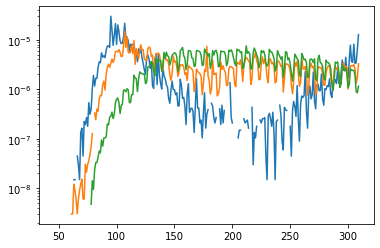

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.yscale("log")
#plt.xscale("log")


#plt.plot(dataFr.dateRep.iloc[::-1] ,dataFr.deaths.iloc[::-1])
#plt.plot(deathWout0.deaths.iloc[::-1])
#plt.plot(deathWout0.deaths[::-1])
#plt.plot(dataFr.deaths.iloc[::-1])
#plt.plot(dataFr.cases.iloc[::-1])


#deathWout0 = 
#print(deathWout0.deaths[::-1])

#print(s)

#plt.plot(s,deathWout0.deaths[::-1])
#plt.plot(s,dataFr.cases.iloc[::-1].where(data.cases > 0))
s = pd.Series(range(len(dataFr.where(data.deaths !=0))))
plt.plot(s,dataFr.where(data.deaths !=0).deaths[::-1]/dataFr.popData2019[::-1])
plt.plot(s,dataUS.where(data.deaths !=0).deaths[::-1]/dataUS.popData2019[::-1])
plt.plot(s,dataBra.where(data.deaths !=0).deaths[::-1]/dataBra.popData2019[::-1])
plt.show()